In [1]:
# %matplotlib widget

In [2]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
import pca_tools
from scipy import stats
seed=2024

### Define functions

In [3]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [6]:
def get_fr_samples(sp,sample_id,start,end,samples,min_trials):
    # parameters

    # Check fr
    ms_fr=np.nanmean(sp[:,start:end])*1000>5
    if not ms_fr:
        return None
    # Average spikes
    #avg_sample = firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = sp[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< min_trials:
            return None
        fr_samples.append(np.mean(sample_fr,axis=0))
    return fr_samples


In [7]:
def get_neuron_sample_fr(path,time_before,start,end,min_trials):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<20:
        return {'fr':None}
    sample_id = neu_data.sample_id[mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51],min_trials=min_trials)
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [8]:
def check_triasl(sp,idx_start,idx_end):
    sig_trials = np.sum(sp,axis=1)>0
    return sig_trials

In [9]:
def select_trials(neu_data,select_block,code,time_before,error_type=0):
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= error_type,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = time_before+400,
        error_type= error_type,
    )
    if np.any(mask_sample != mask_test1):
        return "error"
    return sp_sample_on,sp_test1_on,mask_sample,mask_test1

In [10]:
def get_neuron_sample_test1_fr(path,time_before,start,end,end_test,n_test,min_trials,nonmatch=True,win=50):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,code,time_before,error_type=0)

    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_neu = neu_data.sample_id[mask_test1]==0
    max_test = neu_data.test_stimuli[mask_test1].shape[1]
    mask_ntest = (max_test-np.sum(np.isnan(neu_data.test_stimuli[mask_test1]),axis=1))>(n_test-1)
    #mask_match_neu = np.logical_or(mask_match,mask_neu)
    #mask_match_neu = np.logical_or(np.full(mask_neu.shape,True),mask_neu)
    if nonmatch:
        mask_match_neu = np.logical_or(mask_ntest,mask_neu)
    else:
        mask_match_neu = np.logical_or(mask_match,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
    
   
    avg_sample_on = firing_rate.moving_average(sp_sample_on[mask_match_neu], win=win, step = 1)[:,:time_before+450+400]
    avg_test1_on = firing_rate.moving_average(sp_test1_on[mask_match_neu], win=win, step = 1)[:,time_before:time_before+end_test+400]

    sp=np.concatenate((avg_sample_on,avg_test1_on),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    fr_samples = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51],min_trials=min_trials)
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

### Read data

In [11]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [12]:
area='v4'
neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

In [13]:
# Load data
n_test=1
win=100
min_trials=10
nonmatch=True
time_before=500
start=-200
end_test = n_test*450+200
end=450+400+400+end_test

idx_start = time_before + start 
idx_end = time_before+end

In [14]:
end-start

2100

In [15]:
pp = []
for path in path_list:
    pp.append(path.rsplit('Riesling')[1])

In [16]:
# aa=[]
# loc_change,loc_5,loc_7,loc_10,loc__5,loc__7,loc__10=0,0,0,0,0,0,0
# for n_path in np.unique(pp,return_index=True)[1].tolist():
#     neu_data = NeuronData.from_python_hdf5(path_list[n_path])
#     position = neu_data.position[np.logical_and(neu_data.block==1,neu_data.pos_code==1)]
#     u_pos = np.unique(position,axis=0)
#     if u_pos.shape[0] > 1:
#         loc_change+=1
#     elif np.logical_and(u_pos[0][0][0] == 5, u_pos[0][0][1] == -5):
#         loc_5+=1
#     elif np.logical_and(u_pos[0][0][0] == -5, u_pos[0][0][1] == 5):
#         loc__5+=1
#     elif np.logical_and(u_pos[0][0][0] == 7, u_pos[0][0][1] == -7):
#         loc_7+=1
#     elif np.logical_and(u_pos[0][0][0] == -7, u_pos[0][0][1] == 7):
#         loc__7+=1
#     elif np.logical_and(u_pos[0][0][0] == 10, u_pos[0][0][1] == -10):
#         loc_10+=1
#     elif np.logical_and(u_pos[0][0][0] == -10, u_pos[0][0][1] == 10):
#         loc__10+=1
#     else:
#         print(u_pos[0][0])
#     aa.append(np.unique(position,axis=0))

In [17]:
data = Parallel(n_jobs = -1)(delayed(get_neuron_sample_test1_fr)(path,time_before,start,end,end_test,n_test,min_trials,nonmatch,win) for path in tqdm(path_list))

100%|██████████| 2023/2023 [47:42<00:00,  1.41s/it]


In [18]:
if nonmatch:
    pname_match='_wnonmatch_'
else:
    pname_match='_match_'

In [19]:
neurons_fr = []
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        neurons_fr.append(asc)
basepath = './'#'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/'+area +'/'
to_python_hdf5(dat=neurons_fr, save_path=basepath+area+'_win'+str(win)+'_test'+str(n_test)+pname_match+'min'+str(min_trials)+'tr_pca.h5')

In [20]:
neurons_fr_read=from_python_hdf5(load_path=basepath+area+'_win'+str(win)+'_test'+str(n_test)+pname_match+'min'+str(min_trials)+'tr_pca.h5')
neurons_fr = []
for asc in neurons_fr_read:
    fr = asc["fr"]
    if fr is not None:
        fr_concat = np.concatenate(fr,axis=0)
        neurons_fr.append(fr_concat)

In [21]:
neurons_fr = np.array(neurons_fr)#.reshape(-1,1050)
neurons_fr.shape

(949, 10500)

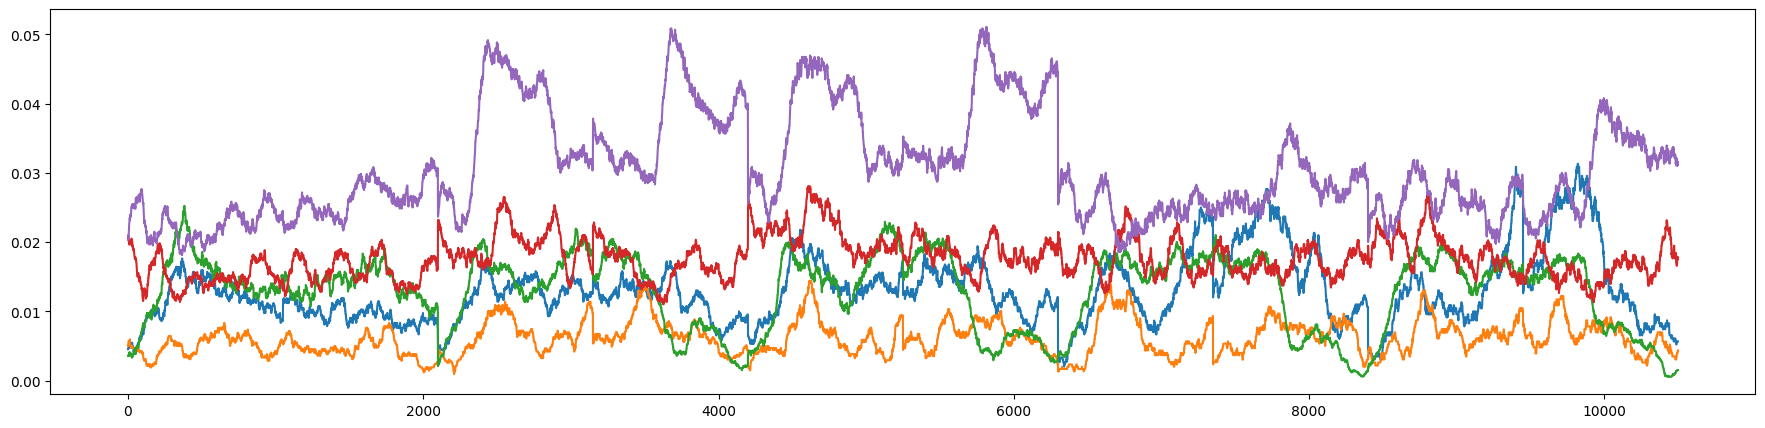

In [22]:
plt.subplots(figsize=(22,5))
_=plt.plot(neurons_fr[0:5].T)

v4: 7 components to explain 80% of the variance


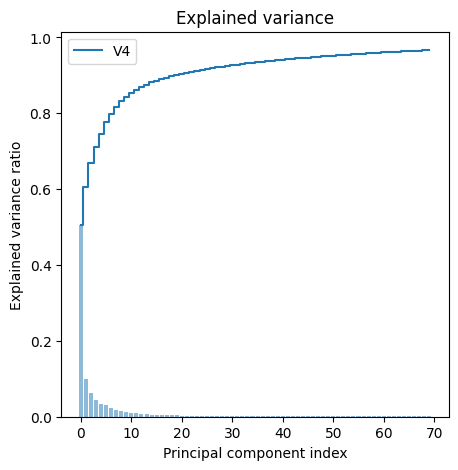

In [23]:
n_comp=70
model,pc_s = pca_tools.compute_pca(neurons_fr,n_comp=n_comp)
pca_tools.plot_explained_var(model,figsize=(5,5),area=area)

In [24]:
# Define epochs
test1_st =200+450+400+400
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d = np.arange(200+450,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test2_st,end-start,2)

In [25]:
pc_s.shape

(70, 10500)

In [26]:
def plot_pc_3d(pcomp, colors, t_epochs, area, figsize=(5, 5)):
    i = 0
    fig, ax = plt.subplots(
        figsize=figsize, sharey=True, sharex=True, subplot_kw={"projection": "3d"}
    )
    for key in t_epochs.keys():
        ax.plot(
            pcomp[i][t_epochs[key]],
            pcomp[i + 1][t_epochs[key]],
            pcomp[i + 2][t_epochs[key]],
            color=colors[key],
            label=key,
            markersize=0.5
        )
        ax.scatter(
            pcomp[i][t_epochs[key]][0],
            pcomp[i + 1][t_epochs[key]][0],
            pcomp[i + 2][t_epochs[key]][0],
            color=colors[key],
            s=30
        )
        ax.scatter(
            pcomp[i][t_epochs[key]],
            pcomp[i + 1][t_epochs[key]],
            pcomp[i + 2][t_epochs[key]],
            color=colors[key],
            s=5
        )

    fig.suptitle(area)
    ax.set(xlabel="PC " + str(i), ylabel="PC " + str(i + 1), zlabel="PC " + str(i + 2))
    ax.legend(
        fontsize=9, columnspacing=0.5, facecolor="white", framealpha=1, loc="best"
    )
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

In [27]:
greyscale=['#000000','#0F0F0F','#3D3D3D','#6B6B6B','#7A7A7A','#999999','#C7C7C7','#D6D6D6']
colors_g=['#001755','#002B95','#0036B3','#1A54D8','#3566DF','#4F79E5','#84A0F0','#9EB4F5']
t_epochs = {'fixation':idx_f,'sample':idx_s,'delay':idx_d,'test1':idx_t1,'test off':idx_aftert}#'test2':idx_t2,'test3':idx_t3,
colors = {'epochs':{'fixation':colors_g[0],'sample':colors_g[1],'delay':colors_g[2],'test1':colors_g[3],'test2':colors_g[4],'test3':colors_g[5],'test4':colors_g[6],'test off':colors_g[-1]}}
colors_neu = {'epochs':{'fixation':greyscale[0],'sample':greyscale[1],'delay':greyscale[2],'test1':greyscale[3],'test2':greyscale[4],'test3':greyscale[5],'test4':greyscale[6],'test off':greyscale[7]}}#

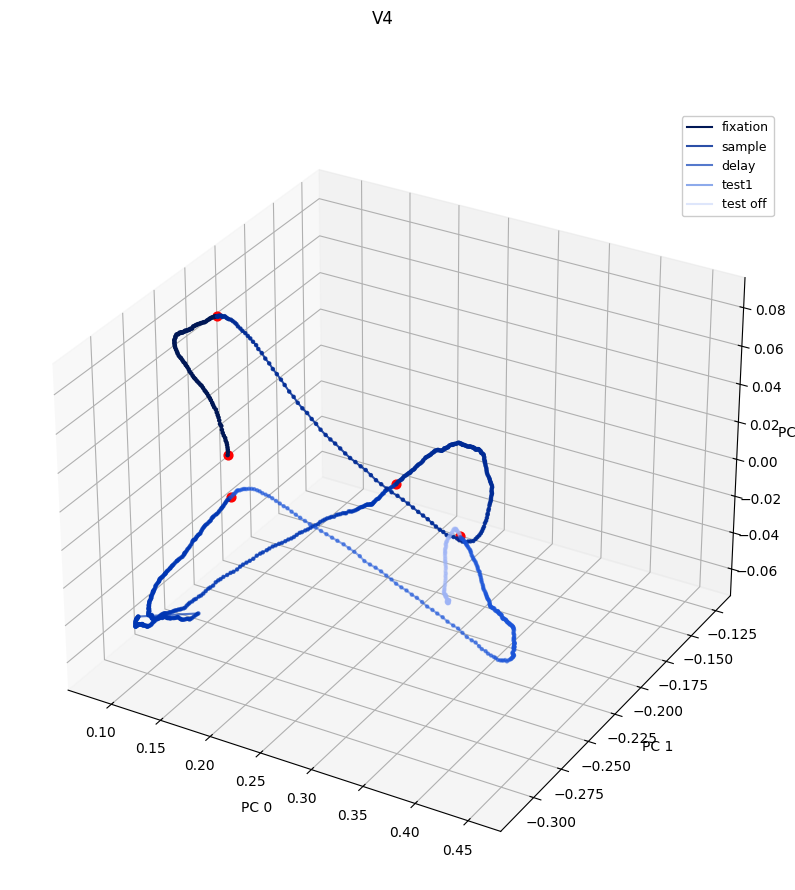

In [28]:
reshape_pc_s = pc_s.reshape(n_comp,-1,end-start)
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
pca_tools.plot_pc_3d(mean_pc_s,colors,t_epochs,area,figsize=(10,10))

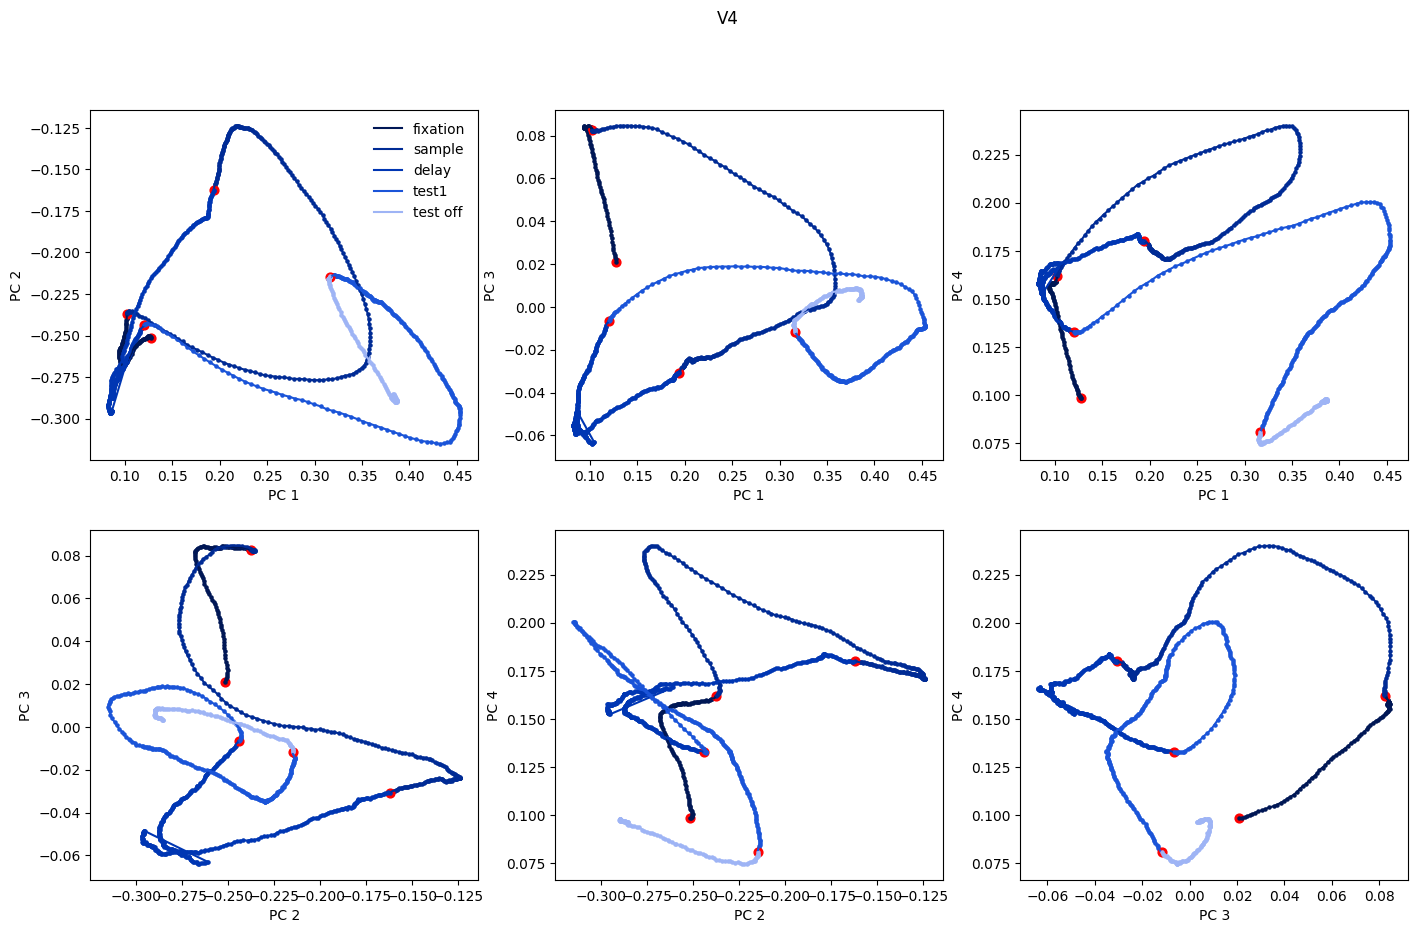

In [29]:
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
fig, ax = plt.subplots(2, 3, figsize=(17,10))
pca_tools.plot_pc(mean_pc_s,colors,t_epochs,area,sample_flag = False,fig=fig, ax=ax)

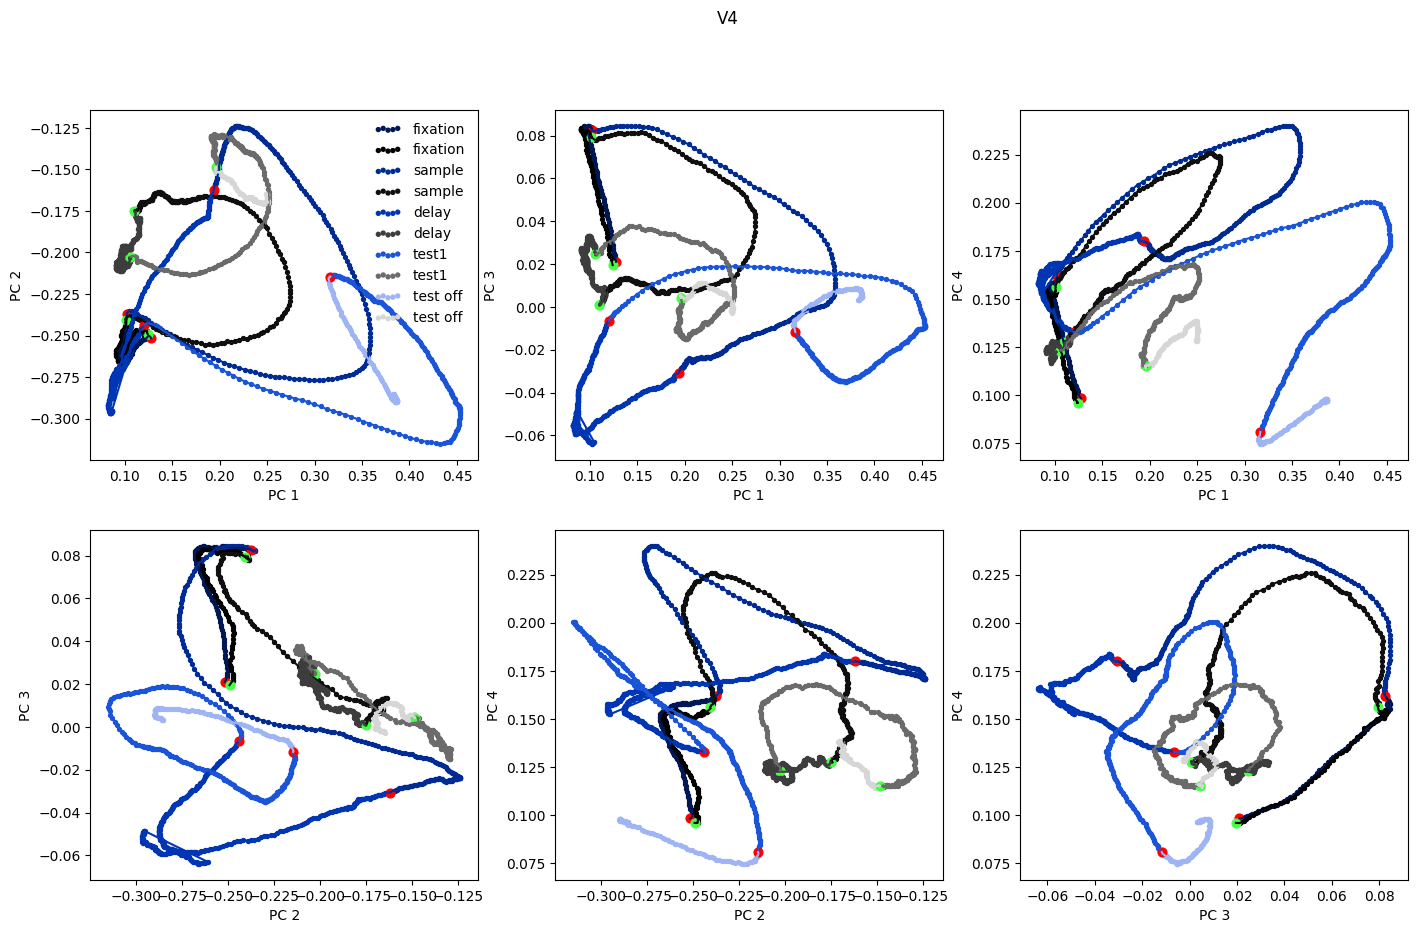

In [30]:
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
fig, ax = plt.subplots(2, 3, figsize=(17,10))
pca_tools.plot_pc_neu(mean_pc_s,reshape_pc_s[:,0],colors,colors_neu,t_epochs,area,fig=fig, ax=ax )

In [31]:
samples={
    "0": 0,
    "11": 1,
    "15": 2,
    "55": 3,
    "51": 4,
    
}

In [32]:
from ephysvibe.task import task_constants

In [33]:
part1=200+450+400

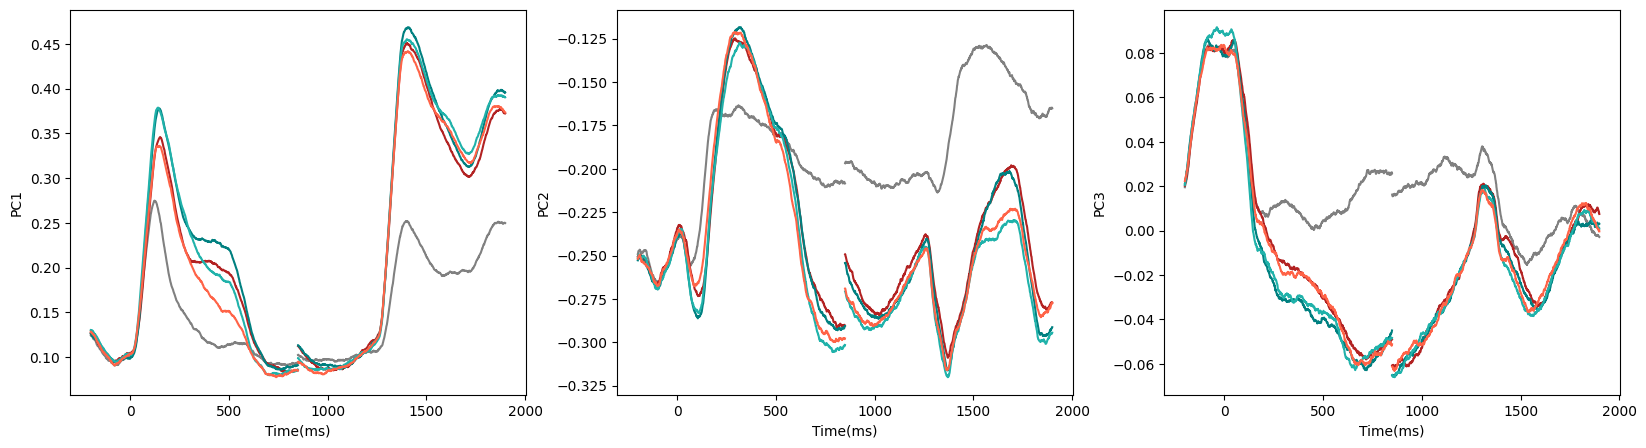

In [34]:
f,ax=plt.subplots(1,3,figsize=(20,5))
for i_sample in samples.keys():
    
    ax[0].plot(range(start,end)[:part1],reshape_pc_s[0,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    #ax[0].vlines(850,0,0.5)
    ax[1].plot(range(start,end)[:part1],reshape_pc_s[1,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[2].plot(range(start,end)[:part1],reshape_pc_s[2,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)

    ax[0].plot(range(start,end)[part1:],reshape_pc_s[0,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    #ax[0].vlines(850,0,0.5)
    ax[1].plot(range(start,end)[part1:],reshape_pc_s[1,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[2].plot(range(start,end)[part1:],reshape_pc_s[2,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample],label=i_sample)

    ax[0].set(xlabel='Time(ms)',ylabel='PC1')
    ax[1].set(xlabel='Time(ms)',ylabel='PC2')
    ax[2].set(xlabel='Time(ms)',ylabel='PC3')